Check out my data preprocessing notebook: https://www.kaggle.com/code/rm1000/holistic-age-prediction-data-preprocessing

Check out my model training notebook: https://www.kaggle.com/code/rm1000/holistic-age-prediction-model-selection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import seaborn as sns
import h5py
import time
import random
import gc
import shap
import torch
from IPython.display import clear_output
!pip uninstall -y seaborn
!pip install seaborn --upgrade
clear_output()
!pip install pacmap
clear_output()
import pacmap
gc.collect()

from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.utils import resample
from catboost import CatBoostRegressor,CatBoostClassifier
from lightgbm import LGBMRegressor
!pip install pytorch_tabnet
clear_output()
from pytorch_tabnet.tab_model import TabNetRegressor

## Loading Data

In [2]:
def load_idmap(idmap_dir):
    idmap = pd.read_csv(idmap_dir, sep=",")
    age = idmap.age.to_numpy()
    age = age.astype(np.float32)
    sample_type = idmap.disease.replace({"control":0, "Alzheimer's disease":1, "schizophrenia":2, "Parkinson's disease":3, "rheumatoid arthritis":4,
                                         "stroke":5, "Huntington's disease":6, "Graves' disease":7, "type 2 diabetes":8, "Sjogren's syndrome":9})
    return age, sample_type

y, sample_type = load_idmap("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/trainmap.csv")
all_ind = pd.DataFrame(sample_type)

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [3]:
control_ind = list(all_ind[all_ind['disease']==0].index)
alzhei_ind = list(all_ind[all_ind['disease']==1].index)
schizo_ind = list(all_ind[all_ind['disease']==2].index)
parkin_ind = list(all_ind[all_ind['disease']==3].index)
rheuma_ind = list(all_ind[all_ind['disease']==4].index)
stroke_ind = list(all_ind[all_ind['disease']==5].index)
huntin_ind = list(all_ind[all_ind['disease']==6].index)
graves_ind = list(all_ind[all_ind['disease']==7].index)
diabet_ind = list(all_ind[all_ind['disease']==8].index)
sjogre_ind = list(all_ind[all_ind['disease']==9].index)
control_y = y[control_ind]
alzhei_y = y[alzhei_ind]
schizo_y = y[schizo_ind]
parkin_y = y[parkin_ind]
rheuma_y = y[rheuma_ind]
stroke_y = y[stroke_ind]
huntin_y = y[huntin_ind]
graves_y = y[graves_ind]
diabet_y = y[diabet_ind]
sjogre_y = y[sjogre_ind]

In [4]:
# 2.5 minutes
full_data = h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r")["data"]
X = full_data[control_ind]
inds = list(range(X.shape[0]))
h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r").close()
del full_data
gc.collect()
clear_output()

In [5]:
# Selecting training and testing data
rand_train = random.sample(inds, 4000)
X_train, y_train = X[rand_train], control_y[rand_train]
remaining_inds = list(set(inds) - set(rand_train))
rand_test = random.sample(remaining_inds, 2000)
X_test, y_test = X[rand_test], control_y[rand_test]
# 6266 samples and 485512 CpG sites
gc.collect()
clear_output()

In [6]:
cpg_lookup = pd.read_csv("/kaggle/input/holistic-age-prediction-using-dna-methylation-data/Processed CpG Information.csv")
cpg_lookup = cpg_lookup.dropna(how='all')
mp = cpg_lookup.isnull().mean() * 100
mp = mp[mp > 0].sort_values(ascending=False)
print(mp.round(2))

Columns (4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


Random_Loci                    99.17
Methyl27_Loci                  94.65
Phantom                        93.40
Probe_SNPs_10                  92.48
DMR                            92.31
Probe_SNPs                     87.67
DHS                            87.66
Enhancer                       78.88
Next_Base                      72.09
AlleleB_ProbeSeq               72.09
Color_Channel                  72.09
AddressB_ID                    72.09
Regulatory_Feature_Name        64.97
Regulatory_Feature_Group       64.97
HMM_Island                     49.43
Relation_to_UCSC_CpG_Island    36.27
UCSC_CpG_Islands_Name          36.27
UCSC_RefGene_Name              24.65
UCSC_RefGene_Group             24.65
UCSC_RefGene_Accession         24.65
Strand                          0.01
Forward_Sequence                0.01
Genome_Build                    0.01
CHR                             0.01
MAPINFO                         0.01
Chromosome_36                   0.01
Coordinate_36                   0.01
S

In [7]:
with open('/kaggle/input/holistic-age-prediction-using-dna-methylation-data/CpG Site Lookup.txt', 'r') as file:
    cpg_storage = [line.strip() for line in file]
cpg_storage = np.array(cpg_storage)

def get_cpg_info(cpg_site):
    return cpg_lookup[cpg_lookup['Name']==cpg_site].dropna(axis=1)

## Feature Selection

In [8]:
# 10 minutes
del X
gc.collect()
clear_output()
# Maybe try checking alphas or normalizing
# 4.81, 4.87, 4.98, 5.02, 5.09, 5.13
lr = Ridge(solver="saga",alpha=100,random_state=42,tol=0.01)
lr.fit(X_train,y_train)
print(mean_absolute_error(lr.predict(X_test),y_test))

5.2116847


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


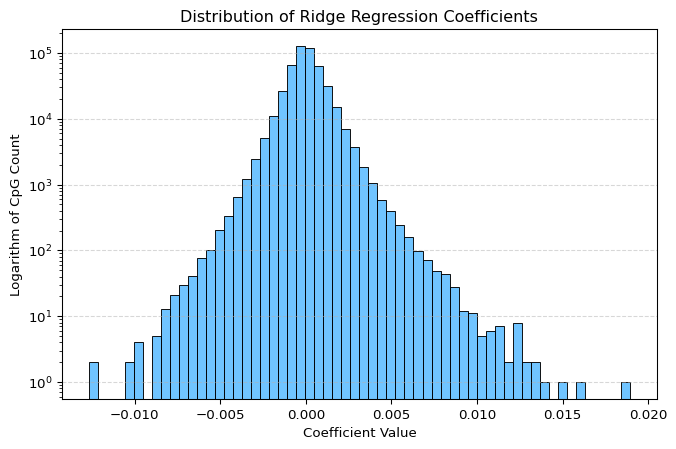

In [9]:
plt.figure(figsize=(8,5), dpi=96)
plt.yscale("log")
sns.histplot(lr.coef_, bins=60, color="#40B0FF")
plt.xlabel("Coefficient Value")
plt.ylabel("Logarithm of CpG Count")
plt.title("Distribution of Ridge Regression Coefficients")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [10]:
coefs = list(lr.coef_)
coefs = [abs(coef) for coef in coefs]
cutoff = round(np.percentile(coefs, 99),5)
print(f"Top 1% cutoff is ±{cutoff}.")
# ~4850 indices
indices = []
for coef,ind in zip(lr.coef_,range(len(lr.coef_))):
    if abs(coef)>cutoff:
        indices.append(ind)
cpg_data = cpg_storage[indices]
# Extracting indices for data
X_train = X_train[:,indices]
X_test = X_test[:,indices]

Top 1% cutoff is ±0.00354.


In [11]:
full_data = h5py.File("/kaggle/input/age-assessment-and-disease-risk-prediction-h5/train.h5", "r")["data"]
X = full_data[control_ind]
X_health = full_data[control_ind][:,indices]
X_alzhei = full_data[alzhei_ind][:,indices]
X_schizo = full_data[schizo_ind][:,indices]
X_parkin = full_data[parkin_ind][:,indices]
X_rheuma = full_data[rheuma_ind][:,indices]
X_stroke = full_data[stroke_ind][:,indices]
X_huntin = full_data[huntin_ind][:,indices]
X_graves = full_data[graves_ind][:,indices]
X_diabet = full_data[diabet_ind][:,indices]
X_sjogre = full_data[sjogre_ind][:,indices]
del full_data
gc.collect()
clear_output()

In [12]:
X_visual = np.concatenate([X_health,X_alzhei,X_schizo,X_parkin,X_rheuma,X_stroke,X_huntin,X_graves,X_diabet,X_sjogre], axis=0)
y_visual = np.concatenate([np.full(X_health.shape[0], 0), np.full(X_alzhei.shape[0], 1), np.full(X_schizo.shape[0], 2), np.full(X_parkin.shape[0], 3), np.full(X_rheuma.shape[0], 4), np.full(X_stroke.shape[0], 5), np.full(X_huntin.shape[0], 6), np.full(X_graves.shape[0], 7), np.full(X_diabet.shape[0], 8), np.full(X_sjogre.shape[0], 9)],axis=0).astype(int)
hex_colors = ["#d5d5d5", "#ffa000", "#0000ff", "#00c000", "#ff0000", "#00c0ff", "#ff00ff", "#005f73", "#8000ff", "#800000"]
cmap_disease = ListedColormap(hex_colors, name="disease10")
conditions = disease_names = ["Control", "Alzheimer's", "Schizophrenia", "Parkinson's", "Rheumatoid Arthritis", "Stroke", "Huntington's", "Graves'", "Type 2 Diabetes", "Sjögren's"]
x,y = np.random.randn(10),np.random.randn(10)

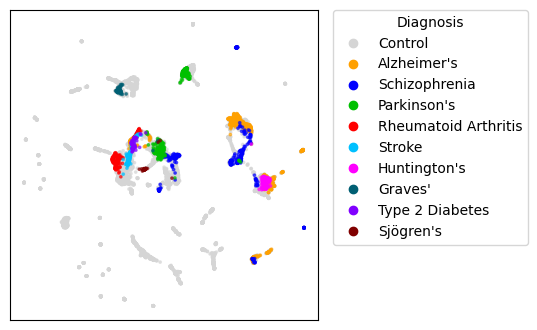

In [13]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
X_trans = embedding.fit_transform(X_visual, init="pca")
fig, ax = plt.subplots(1, 1, figsize=(5.54, 3.4), dpi=100)
sc = ax.scatter(X_trans[:, 0], X_trans[:, 1], c=y_visual, cmap=cmap_disease, s=3, alpha=0.6)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
handles = [Line2D([0],[0], marker="o", linestyle="", color=hex_colors[i], markersize=6, label=disease_names[i]) for i in range(10)]
ax.legend(handles=handles, title="Diagnosis", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
plt.show()

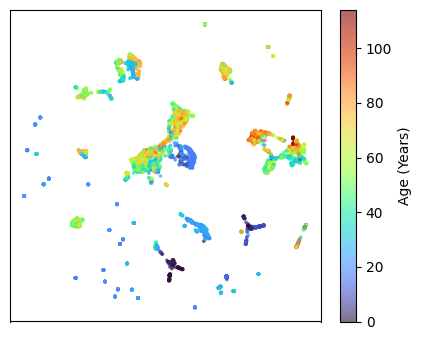

In [14]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
X_trans = embedding.fit_transform(X_health, init="pca")
fig, ax = plt.subplots(1, 1, figsize=(4.37, 3.5), dpi=100)
sc = ax.scatter(X_trans[:, 0], X_trans[:, 1], cmap='turbo', c=control_y, s=3, alpha=0.6) # rainbow
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Age (Years)")
plt.tight_layout()
plt.show()

In [15]:
del X_trans,X
gc.collect()
clear_output()

## Retraining Top 4 Models

In [16]:
# 2.65 target
# 2.54, 2.54, 2.54, 2.59, 2.61, 2.61, 2.65, 2.76, 2.80
cat_model = CatBoostRegressor(iterations=3200,min_data_in_leaf=1,learning_rate=0.03,max_leaves=50,l2_leaf_reg=0.1,grow_policy='Lossguide',logging_level='Silent',task_type='GPU')
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_mae = mean_absolute_error(cat_preds,y_test)
print(round(cat_mae,3))

2.725


In [17]:
# 2.90 target
# 2.77, 2.78, 2.78, 2.79, 2.80, 2.89, 2.90, 2.96, 2.99,   
lgbm_model = LGBMRegressor(n_estimators=150, learning_rate=0.1, num_leaves=80, subsample=0.9)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)
lgbm_mae = mean_absolute_error(lgbm_preds,y_test)
print(round(lgbm_mae,3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.576173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050372
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 4879
[LightGBM] [Info] Start training from score 48.338718
2.978


In [18]:
# 2.99 target
# 2.87, 2.91, 2.95, 2.96, 2.96, 2.96, 2.99, 3.06, 3.12
gb_model = GradientBoostingRegressor(n_estimators=12, learning_rate=0.6, max_depth=17, init=SVR(kernel='poly',degree=2,shrinking=True,gamma='auto',C=1.5,epsilon=0.1,tol=0.01,coef0=0.24,max_iter=2500))
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_mae = mean_absolute_error(gb_preds,y_test)
print(round(gb_mae,3))

Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


3.015


In [19]:
# 3.02 target
# 2.89, 2.96, 3.00, 3.02, 3.05, 3.15
tab_model = TabNetRegressor(momentum=0.02,gamma=1.2,lambda_sparse=0.00015,n_d=12,n_a=8,device_name='cuda')
tab_model.fit(X_train, y_train.reshape(-1, 1), eval_metric=['mae'], eval_set=[(X_test,y_test.reshape(-1, 1))],max_epochs=200,patience=20)
clear_output()
tab_preds = tab_model.predict(X_test)[:,0]
tab_mae = mean_absolute_error(tab_preds,y_test)
print(round(tab_mae,3))

3.216


## Error Visualizations

In [20]:
def three_error_graphs(model_preds,real_values,model_name="",disease_name=""):
    if disease_name=="":
        titles = [f"Actual vs Predicted Age with {model_name}",f"{model_name}'s Residual Error vs Age",f"{model_name}'s Mean Absolute Error by Age Bin"]
    else:
        titles = [f"Actual vs Predicted Age for {disease_name}", f"Residual Error vs Age for {disease_name}", f"Mean Absolute Error by Age Bin for {disease_name}"]
        mae = round(mean_absolute_error(model_preds,real_values),3)
        results[disease_name] = mae
        print("Mean Ensemble had MAE of", mae, "for", disease_name)
    # Graph 1
    plt.figure(figsize=(6,6),dpi=96)
    sns.scatterplot(x=real_values, y=model_preds, alpha=0.6, color='#0080ff')
    plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], linestyle='--', color='#590099', linewidth=2.5)
    plt.xlabel("Chronological Age")
    plt.ylabel("Predicted Age")
    plt.title(titles[0])
    plt.show()
    # Graph 2
    errors = real_values-model_preds
    if disease_name!="":
        residuals[disease_name] = errors
    plt.figure(figsize=(7,5), dpi=96)
    sns.scatterplot(x=real_values, y=errors, color='#0080ff', alpha=0.6)
    plt.axhline(0, linestyle='--', color='#590099', linewidth=2.5)
    plt.xlabel("Chronological Age")
    plt.ylabel("Residual Error (Actual - Predicted)")
    plt.title(titles[1])
    plt.show()
    # Graph 3
    #bins = pd.cut(real_values, bins=[0, 20, 40, 60, 80, 100])
    lbound,hbound = max(0,min(real_values)),min(100,max(real_values))
    step = (hbound-lbound)//5
    if disease_name=="":
        bins = pd.cut(real_values, bins=[0, 20, 40, 60, 80, 100])
    elif disease_name=='Type 2 Diabetes':
        bins = pd.cut(real_values, bins=[65, 70, 75, 80, 85, 90])
    else:
        bins = pd.cut(real_values, bins=list(map(int,list(np.arange(lbound, hbound, step)))))
    bin_mae = pd.Series(index=bins.categories, dtype=float)
    for b in bins.categories:
        mask = bins == b
        if mask.sum() == 0:
            bin_mae[b] = 0.0
        else:
            bin_mae[b] = mean_absolute_error(real_values[mask], model_preds[mask])
    plt.figure(figsize=(6, 4.5), dpi=96)
    bin_mae.plot(
        kind='bar',
        color='#40B0FF',
        edgecolor='black'
    )
    plt.title(titles[2])
    plt.ylabel("MAE (years)")
    plt.xlabel("Age Bin")
    plt.xticks(rotation=0, ha='center')
    plt.show()

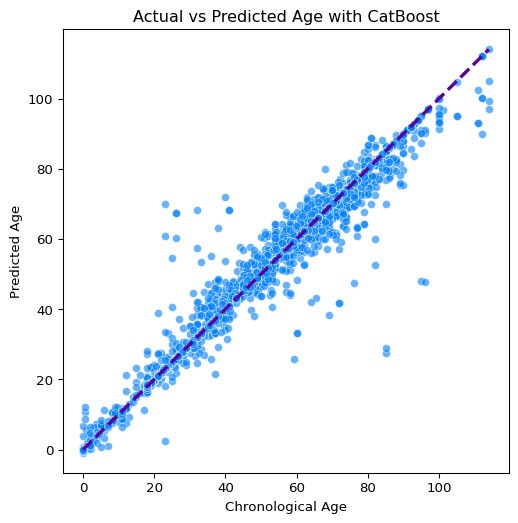

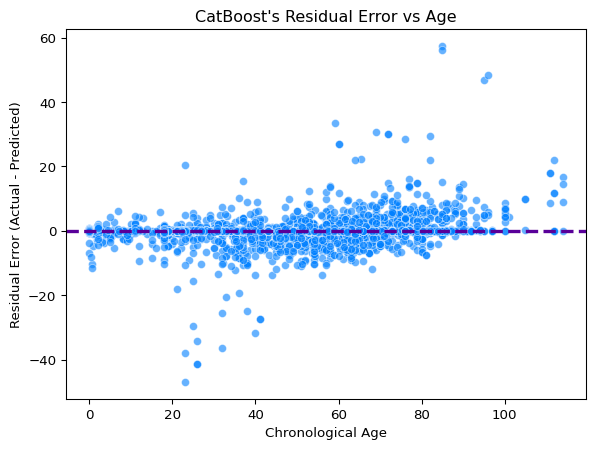

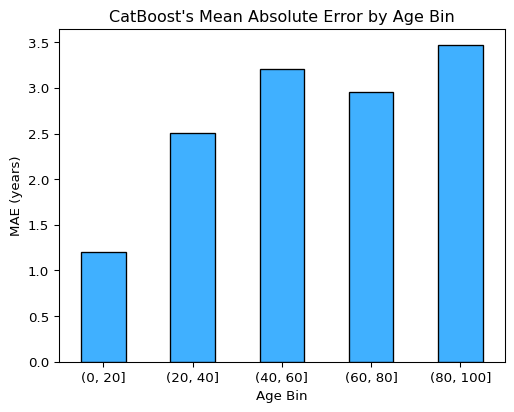

In [21]:
three_error_graphs(cat_preds,y_test,model_name='CatBoost')

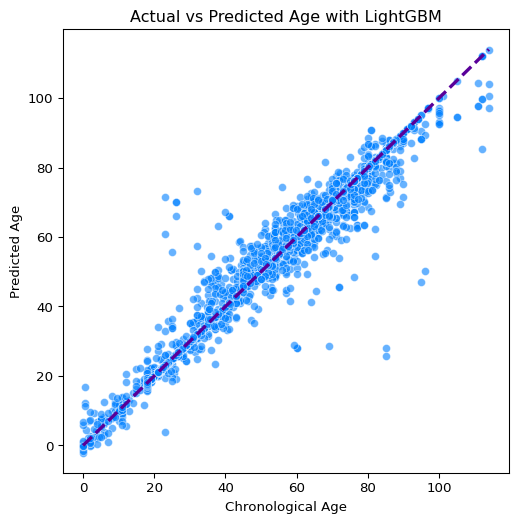

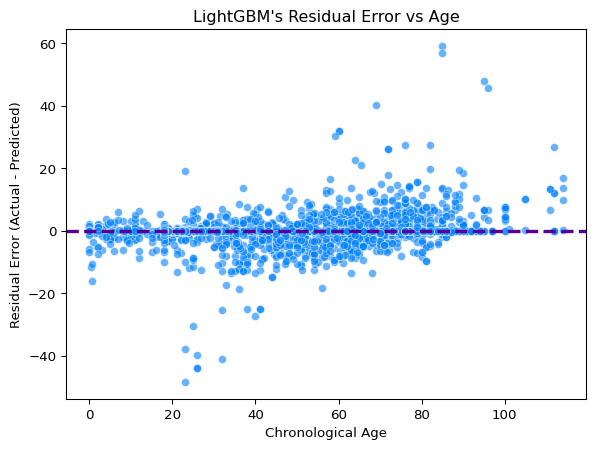

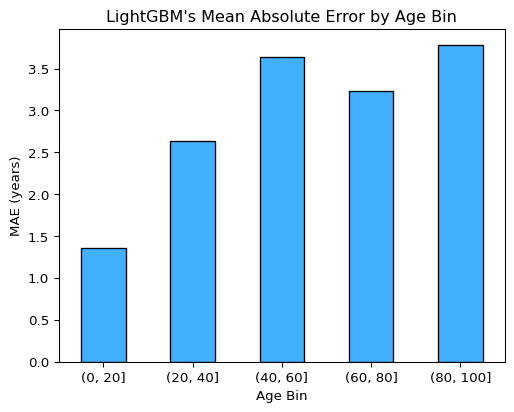

In [22]:
three_error_graphs(lgbm_preds,y_test,model_name='LightGBM')

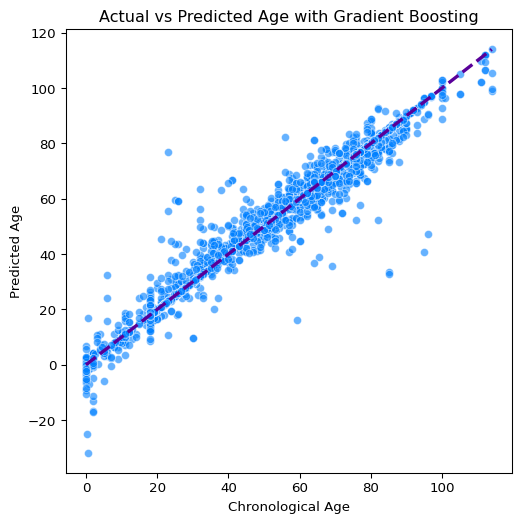

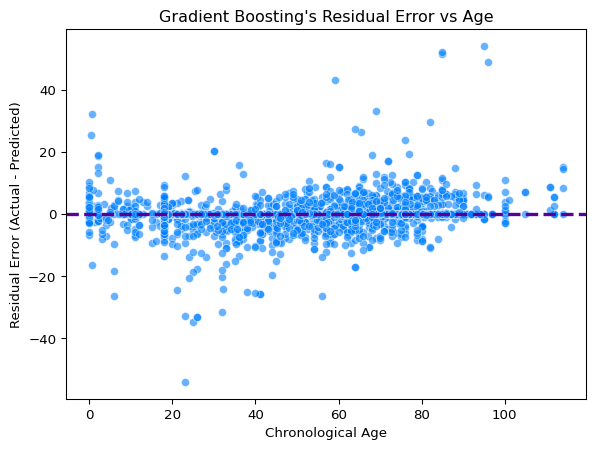

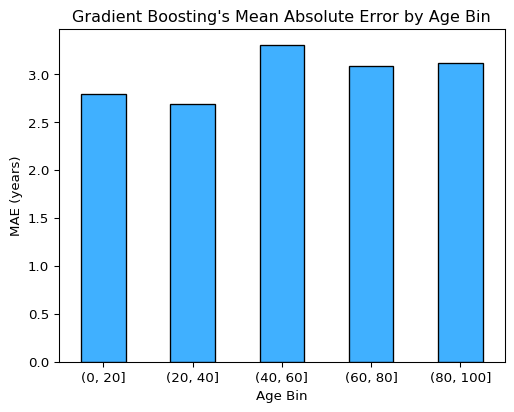

In [23]:
three_error_graphs(gb_preds,y_test,model_name='Gradient Boosting')

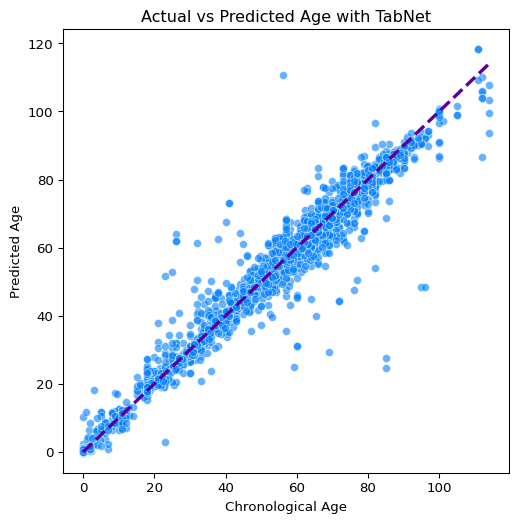

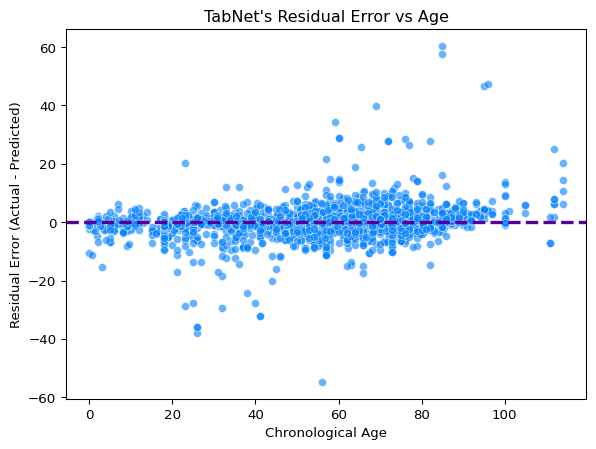

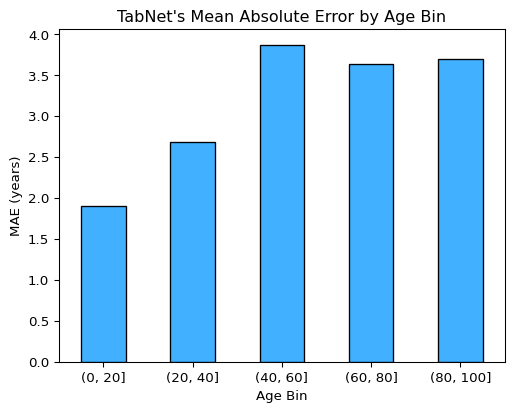

In [24]:
three_error_graphs(tab_preds,y_test,model_name='TabNet')

## Interpretability and CpG Site Selection

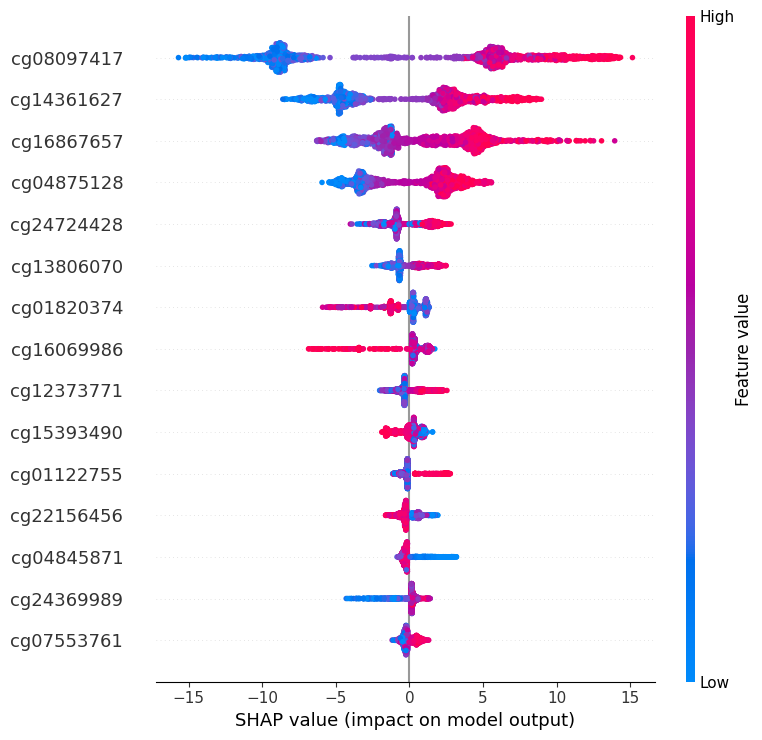

In [25]:
explainer = shap.Explainer(cat_model)
control_shap = explainer(X_test)
control_shap.feature_names = cpg_data
shap.summary_plot(control_shap, X_test, max_display=15)

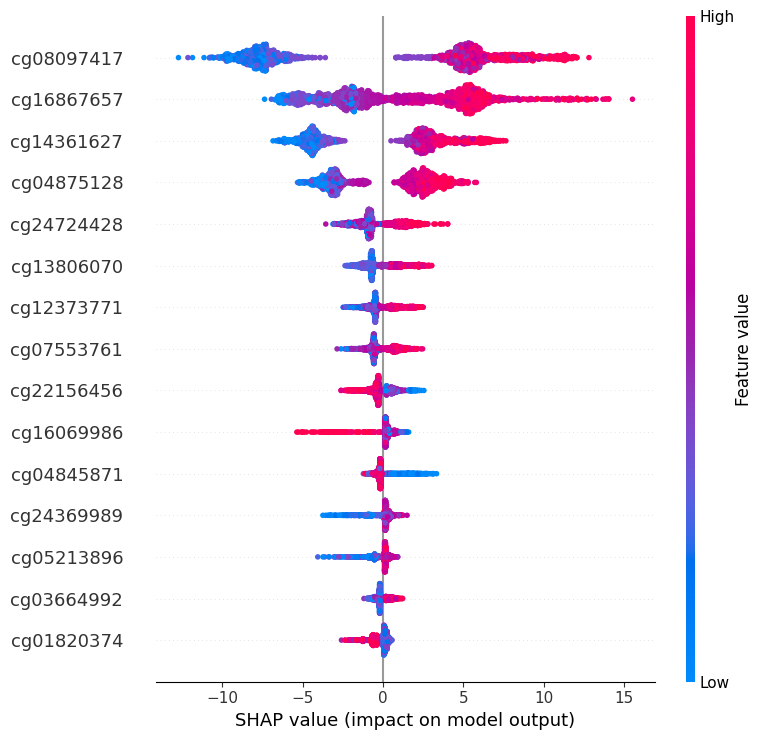

In [26]:
explainer = shap.Explainer(lgbm_model)
control_shap = explainer(X_test)
control_shap.feature_names = cpg_data
shap.summary_plot(control_shap, X_test, max_display=15)

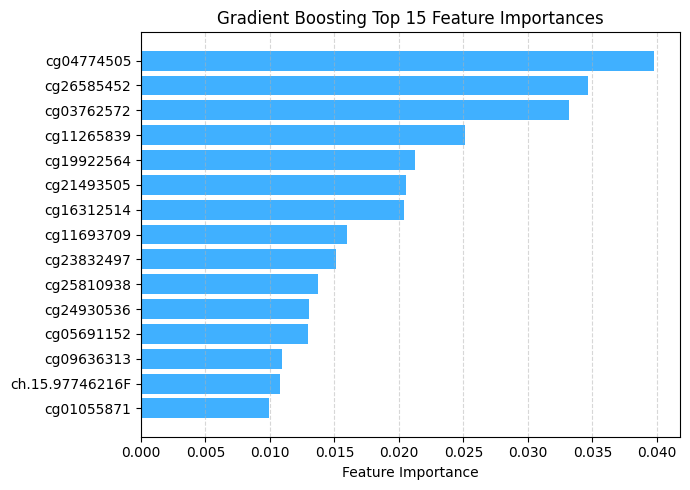

In [27]:
importances = gb_model.feature_importances_
feature_names = cpg_data
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(7, 5))
plt.barh(fi_df['Feature'], fi_df['Importance'], color='#40B0FF')
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

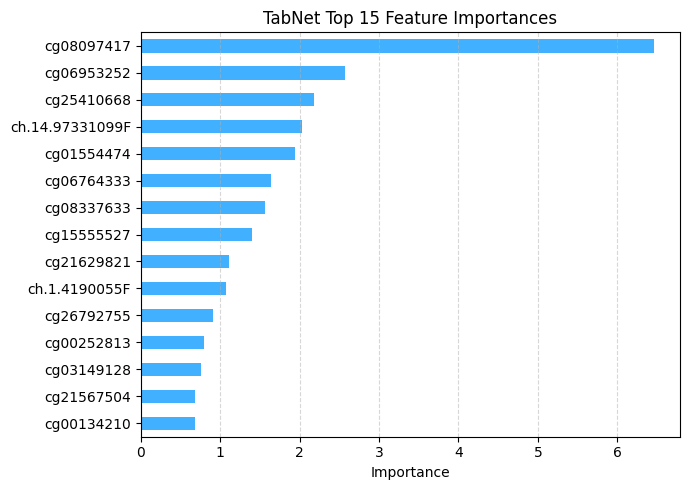

In [28]:
X_test_tensor = torch.tensor(X_test.astype(np.float32)).to(tab_model.device_name)
M_explain, masks = tab_model.explain(X_test_tensor, normalize=False)
global_importance = np.mean(M_explain, axis=0)
top_indices = np.argsort(global_importance)[::-1][:15]
top_features = [cpg_data[i] for i in top_indices]
top_values = global_importance[top_indices]

pd.Series(top_values, index=top_features).plot(
    kind='barh',
    color='#40B0FF',
    figsize=(7, 5)
)
plt.title("TabNet Top 15 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [29]:
get_cpg_info('cg24673101')
# Find themes (brain stuff, T cell, signaling pathway, ubiquitin, zinc finger, mitosis/meiosis, Wnt signaling etc.)

,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,Infinium_Design_Type,Forward_Sequence,Genome_Build,CHR,MAPINFO,SourceSeq,Chromosome_36,Coordinate_36,Strand,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,HMM_Island
364474,cg24673101,cg24673101,28707506.0,CCCTACTACRCRAAAACCTAAAACTCAAAAAACTAATACTACTACT...,II,CGCCCCCGCCGCCGCCGCCACCGCTTGCGGCCCCCGTCGCCGCCAG...,37.0,14,100069840.0,CCTGCTGCGCGAGAACCTGGAGCTCAAGGAGCTGGTGCTGCTGCTG...,14,99139593,F,CCDC85C,NM_001144995,1stExon,chr14:100069475-100071813,Island,14:99138944-99141655


https://www.science.org/doi/10.1126/scisignal.2004510 BMP8A cg03664992 cg13806070

https://epigeneticsandchromatin.biomedcentral.com/articles/10.1186/s13072-018-0191-3 ELOVL2 cg16867657 cg21572722 cg24724428

https://www.nature.com/articles/s41598-025-01536-8 KLF14 cg08097417 cg14361627

https://pubmed.ncbi.nlm.nih.gov/30439595/ ANKMY1 cg20002504

https://pubmed.ncbi.nlm.nih.gov/23328665/ ASL cg09748749

https://www.nature.com/articles/ncomms4547 CD8A cg04329870

CECR6 cg12373771

https://www.nature.com/articles/onc2012344 CHRNB4 cg24369989

https://pmc.ncbi.nlm.nih.gov/articles/PMC11343201/ EIF1 cg22156456

https://pmc.ncbi.nlm.nih.gov/articles/PMC12118595/ ELK3 cg11265839

https://www.nature.com/articles/ncomms11089 FAM123C cg23606718

https://pmc.ncbi.nlm.nih.gov/articles/PMC8534169/ FHL2 cg22454769

https://onlinelibrary.wiley.com/doi/10.1002/humu.20046 IDS cg09761247

LAG3 cg01820374

MARCH11 cg23479922

MIR503 cg07194250

NHLRC1 cg22736354

NSD1 cg08369368

OTUD7A cg04875128

PRDM2 cg23813012

PRRT1 cg18501647

SCGN cg06493994

SHANK2 cg16069986

SMAD2 cg17243289

TRIM59 cg07553761

ZFYVE21 cg26242531

## Mean Ensembling

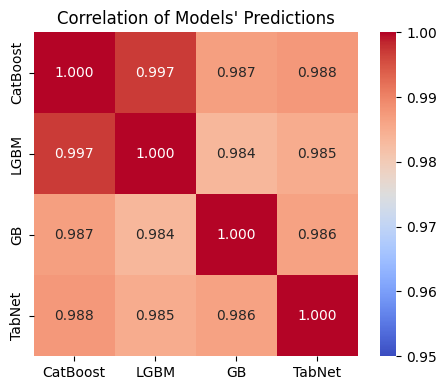

In [30]:
df_preds = pd.DataFrame({
    "CatBoost": cat_preds,
    "LGBM": lgbm_preds,
    "GB": gb_preds,
    "TabNet": tab_preds
})
corr_matrix = df_preds.corr()
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, vmin=0.95, vmax=1.0)
plt.title("Correlation of Models' Predictions")
plt.tight_layout()
plt.show()

In [31]:
# 2.388 2.419 2.458 2.500 2.550 2.611
inv_maes = 1 / np.array([cat_mae, lgbm_mae, gb_mae, tab_mae])**2
weights = inv_maes / inv_maes.sum()
print("Model Weights are", [round(weight,3) for weight in weights])

Model Weights are [0.297, 0.248, 0.242, 0.213]


In [32]:
def ensemble_preds(X_disease):
    cat_dpreds = cat_model.predict(X_disease)
    lgbm_dpreds = lgbm_model.predict(X_disease)
    gb_dpreds = gb_model.predict(X_disease)
    tab_dpreds = tab_model.predict(X_disease)[:,0]
    return (weights[0]*cat_dpreds + weights[1]*lgbm_dpreds + weights[2]*gb_dpreds + weights[3]*tab_dpreds)

## Disease Visualizations

In [33]:
results = dict()
residuals = dict()
control_ypred = ensemble_preds(X_test)
alzhei_ypred = ensemble_preds(X_alzhei)
schizo_ypred = ensemble_preds(X_schizo)
parkin_ypred = ensemble_preds(X_parkin)
rheuma_ypred = ensemble_preds(X_rheuma)
stroke_ypred = ensemble_preds(X_stroke)
huntin_ypred = ensemble_preds(X_huntin)
graves_ypred = ensemble_preds(X_graves)
diabet_ypred = ensemble_preds(X_diabet)
sjogre_ypred = ensemble_preds(X_sjogre)

Mean Ensemble had MAE of 2.592 for Control


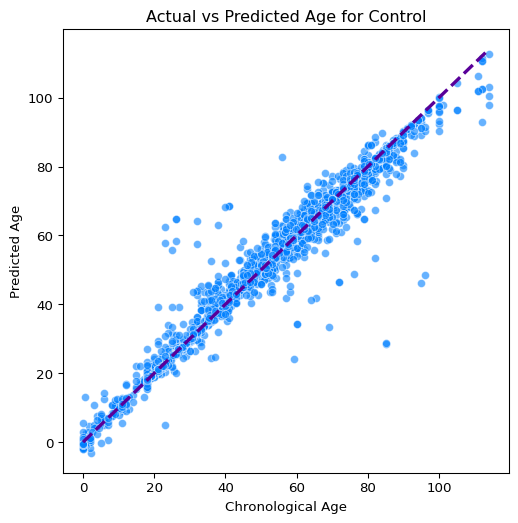

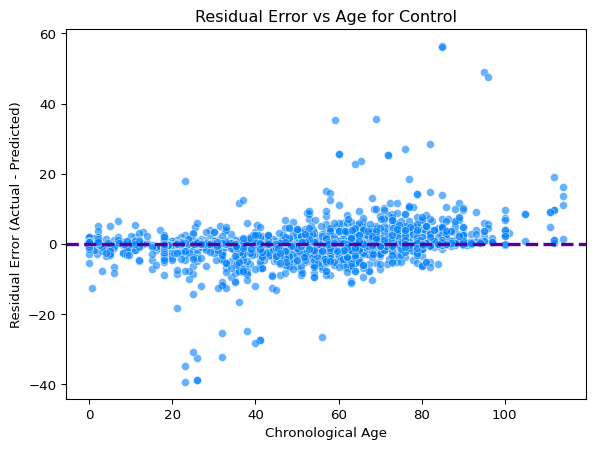

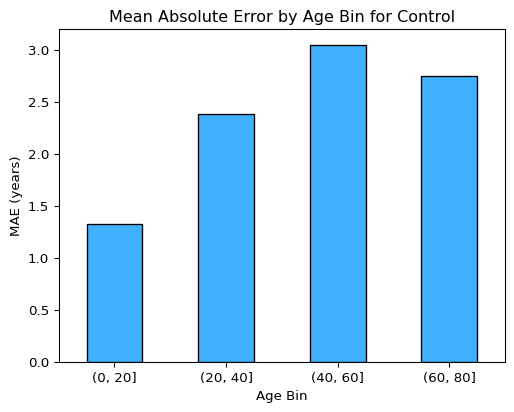

In [34]:
three_error_graphs(control_ypred,y_test,disease_name="Control")

Mean Ensemble had MAE of 3.985 for Alzheimer's


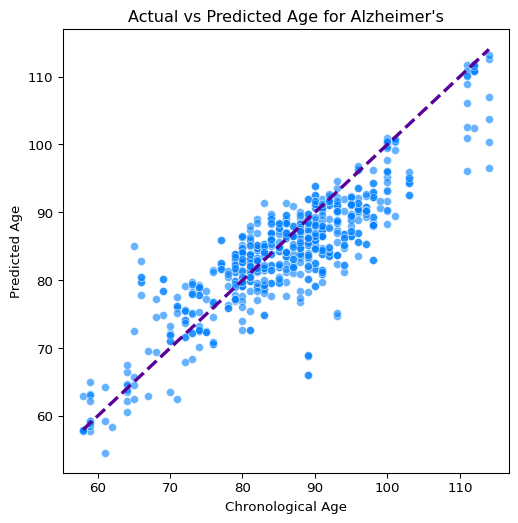

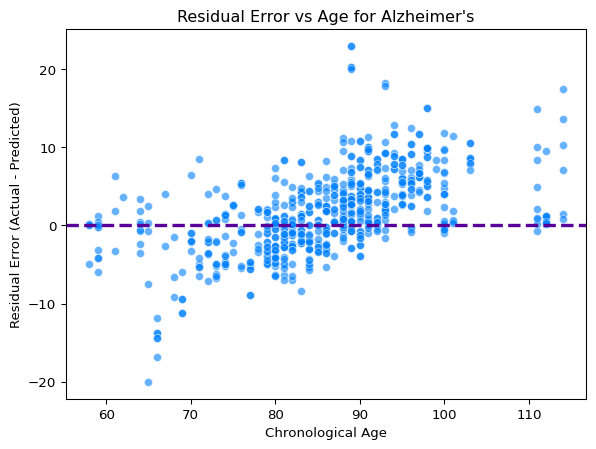

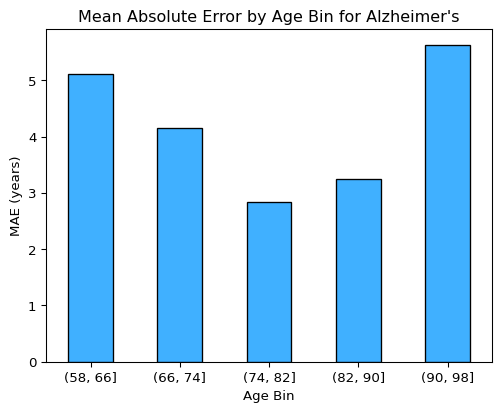

In [35]:
three_error_graphs(alzhei_ypred,alzhei_y,disease_name="Alzheimer's")

Mean Ensemble had MAE of 4.327 for Schizophrenia


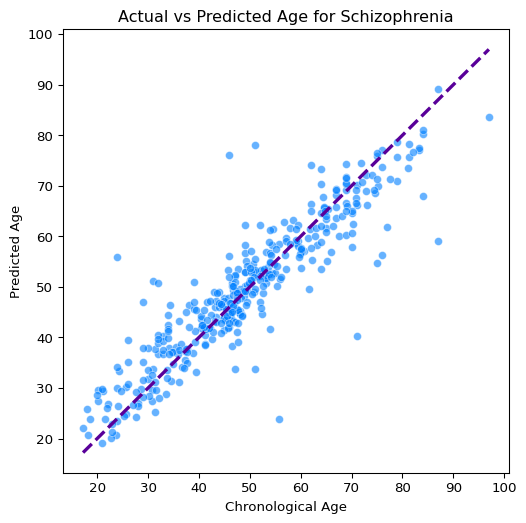

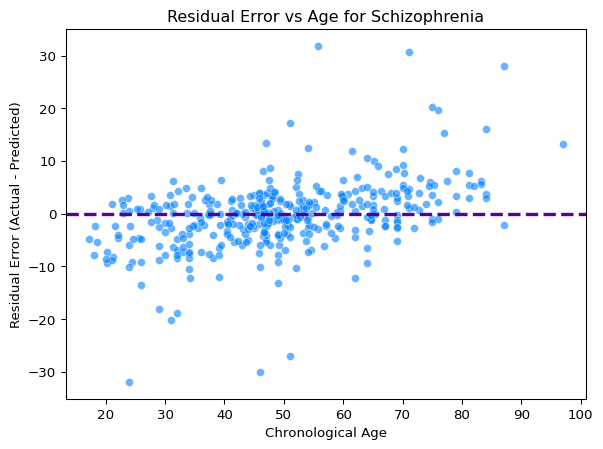

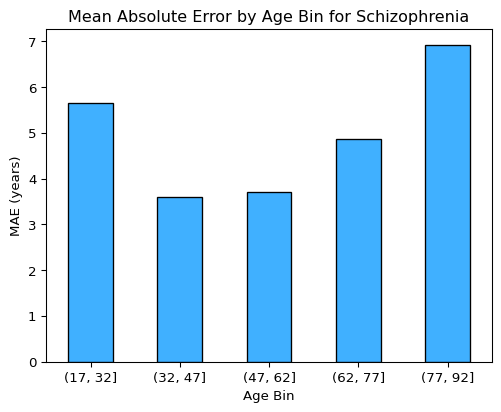

In [36]:
three_error_graphs(schizo_ypred,schizo_y,disease_name="Schizophrenia")

Mean Ensemble had MAE of 3.503 for Parkinson's


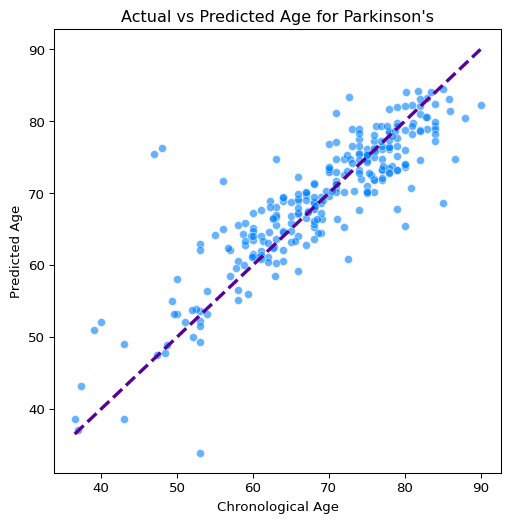

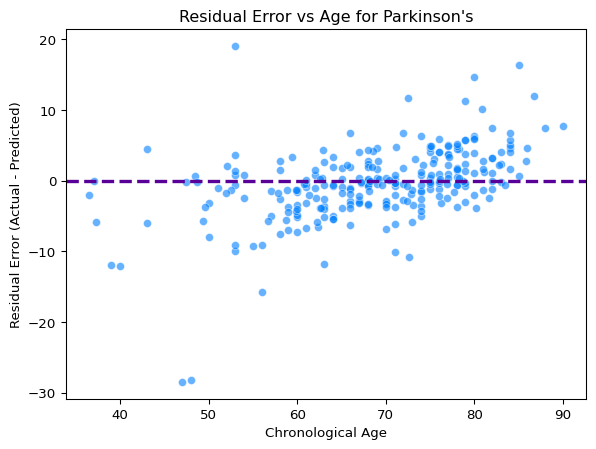

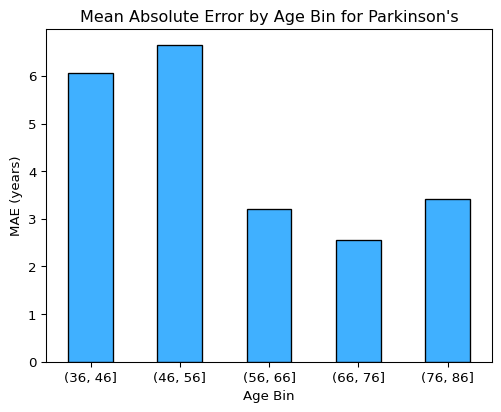

In [37]:
three_error_graphs(parkin_ypred,parkin_y,disease_name="Parkinson's")

Mean Ensemble had MAE of 3.113 for Rheumatoid Arthritis


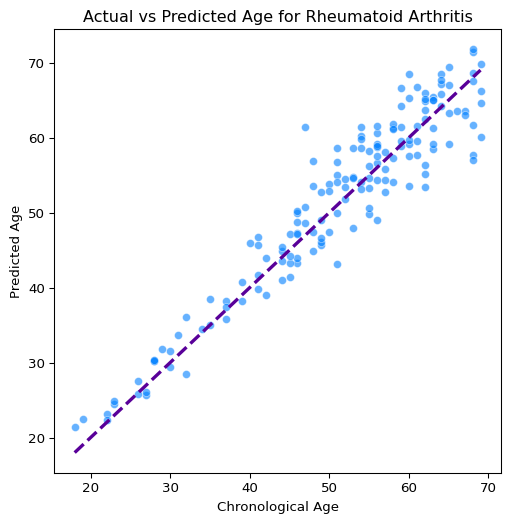

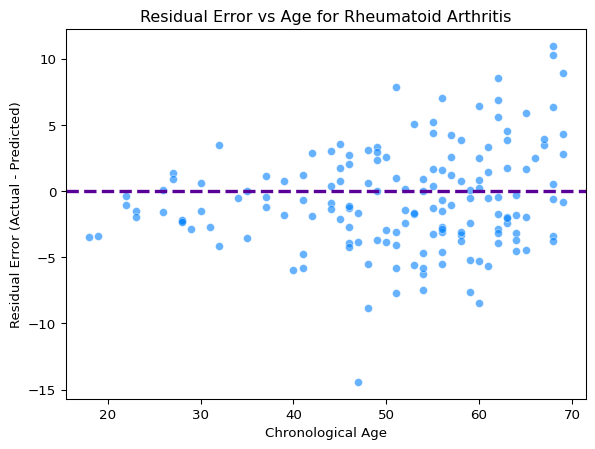

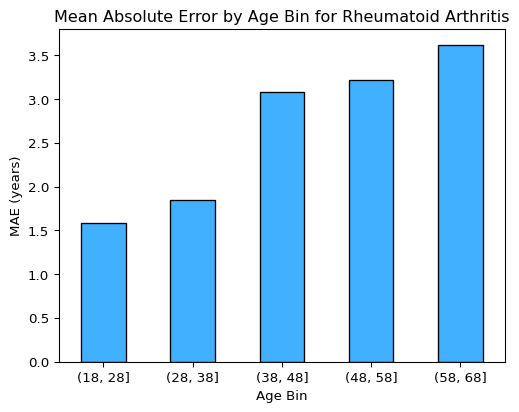

In [38]:
three_error_graphs(rheuma_ypred,rheuma_y,disease_name="Rheumatoid Arthritis")

Mean Ensemble had MAE of 6.566 for Stroke


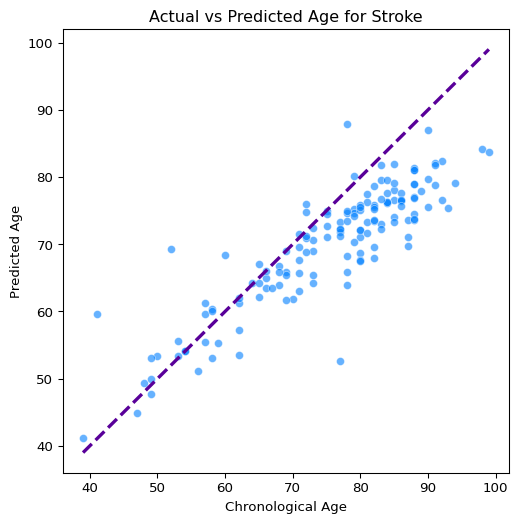

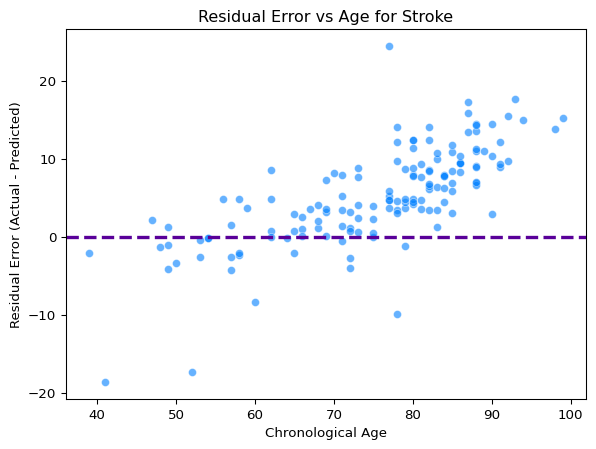

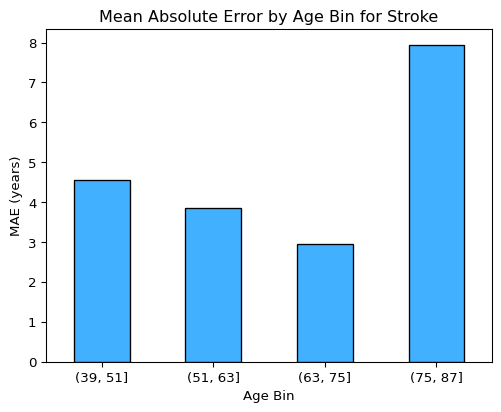

In [39]:
three_error_graphs(stroke_ypred,stroke_y,disease_name="Stroke")

Mean Ensemble had MAE of 3.367 for Huntington's


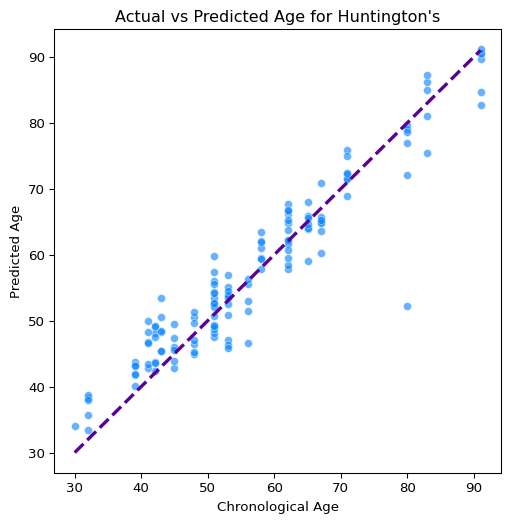

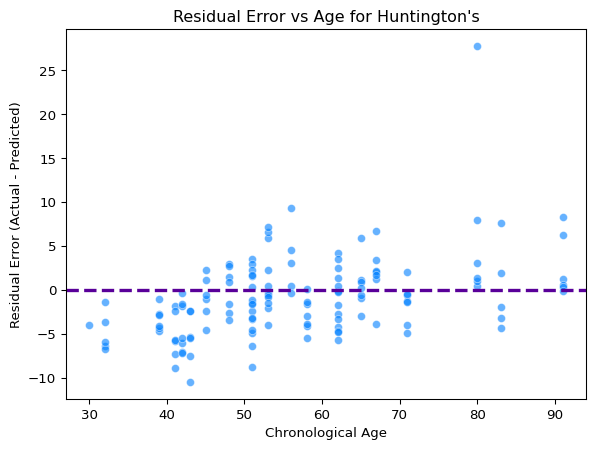

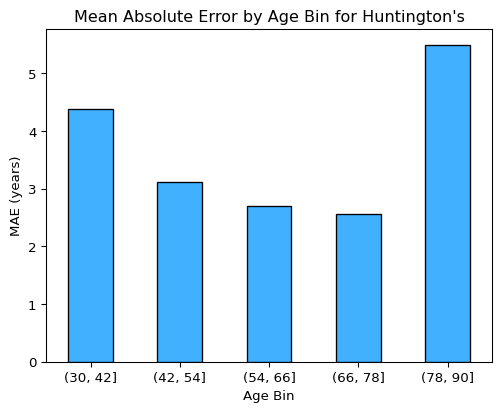

In [40]:
three_error_graphs(huntin_ypred,huntin_y,disease_name="Huntington's")

Mean Ensemble had MAE of 4.428 for Graves'


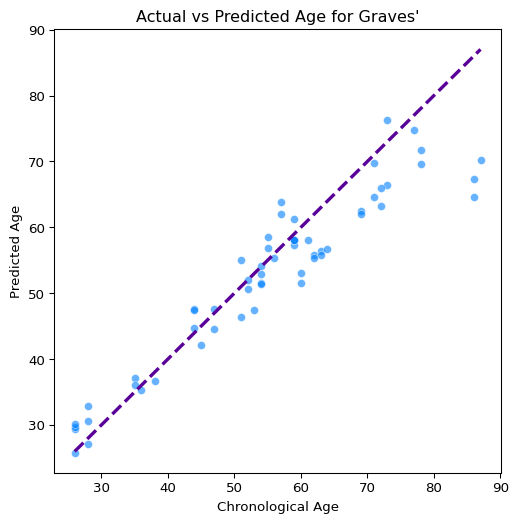

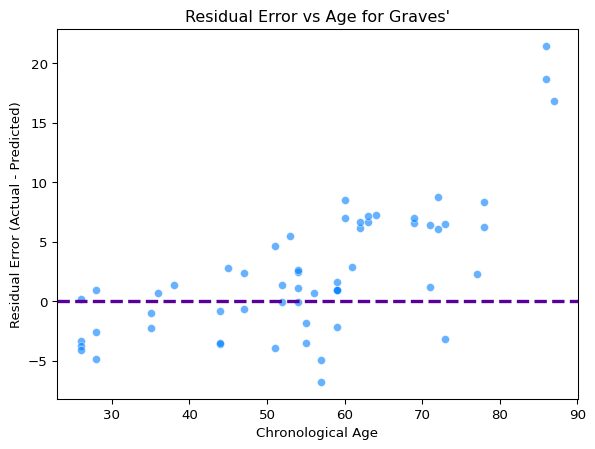

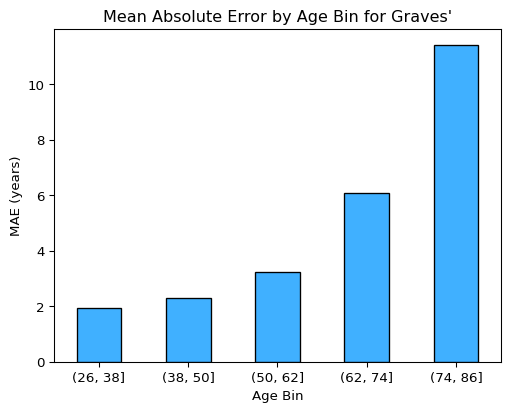

In [41]:
three_error_graphs(graves_ypred,graves_y,disease_name="Graves'")

Mean Ensemble had MAE of 3.196 for Type 2 Diabetes


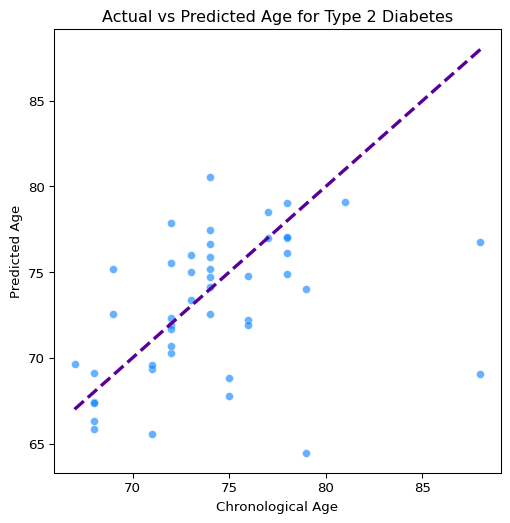

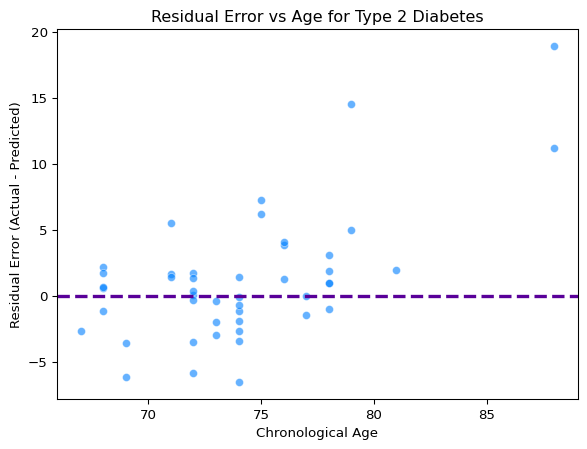

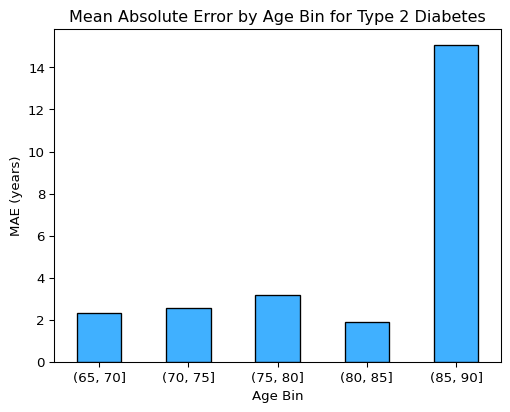

In [42]:
three_error_graphs(diabet_ypred,diabet_y,disease_name="Type 2 Diabetes")

Mean Ensemble had MAE of 2.875 for Sjögren's


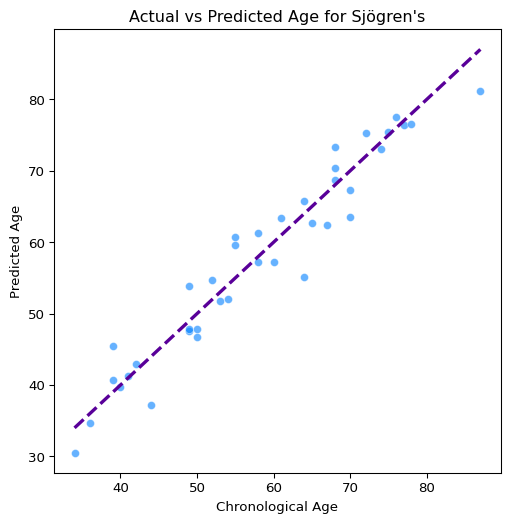

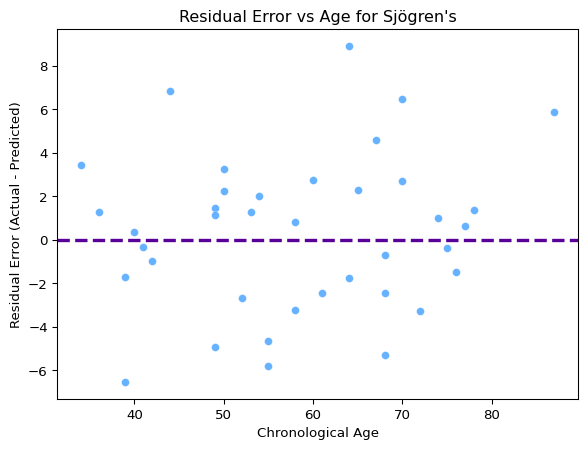

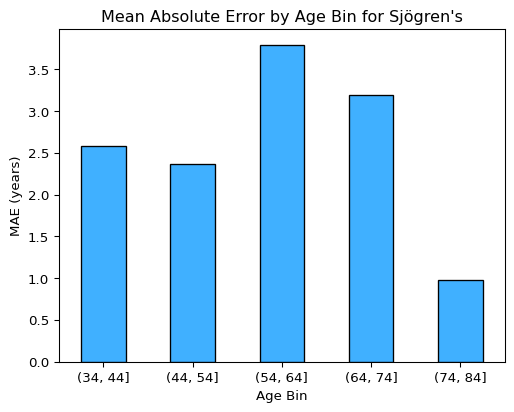

In [43]:
three_error_graphs(sjogre_ypred,sjogre_y,disease_name="Sjögren's")

In [44]:
vresults = sorted(results.items(), key=lambda v: v[1])
dis_names = [k for k,v in vresults]
dis_mae = [v for k,v in vresults]
vresults

[('Control', 2.592),
 ("Sjögren's", 2.875),
 ('Rheumatoid Arthritis', 3.113),
 ('Type 2 Diabetes', 3.196),
 ("Huntington's", 3.367),
 ("Parkinson's", 3.503),
 ("Alzheimer's", 3.985),
 ('Schizophrenia', 4.327),
 ("Graves'", 4.428),
 ('Stroke', 6.566)]

## Disease Comparison

In [45]:
def confidence_ints(true_y,pred_y):
    maes = []
    for _ in range(10000):
        y_resample, pred_resample = resample(true_y, pred_y)
        maes.append(mean_absolute_error(y_resample, pred_resample))
    ci_lower,ci_upper = np.percentile(maes, [2.5,97.5])
    return round(ci_lower,3),round(ci_upper,3)

In [46]:
confident_results = {k:[results[k]] for k in results}
confident_results['Control'] += list(confidence_ints(y_test,control_ypred))
confident_results["Alzheimer's"] += list(confidence_ints(alzhei_y,alzhei_ypred))
confident_results["Schizophrenia"] += list(confidence_ints(schizo_y,schizo_ypred))
confident_results["Parkinson's"] += list(confidence_ints(parkin_y,parkin_ypred))
confident_results["Rheumatoid Arthritis"] += list(confidence_ints(rheuma_y,rheuma_ypred))
confident_results["Stroke"] += list(confidence_ints(stroke_y,stroke_ypred))
confident_results["Huntington's"] += list(confidence_ints(huntin_y,huntin_ypred))
confident_results["Graves'"] += list(confidence_ints(graves_y,graves_ypred))
confident_results["Type 2 Diabetes"] += list(confidence_ints(diabet_y,diabet_ypred))
confident_results["Sjögren's"] += list(confidence_ints(sjogre_y,sjogre_ypred))
vcresults = dict(sorted(confident_results.items(), key=lambda v: v[1]))
vcresults

{'Control': [2.592, 2.397, 2.799],
 "Sjögren's": [2.875, 2.226, 3.562],
 'Rheumatoid Arthritis': [3.113, 2.75, 3.501],
 'Type 2 Diabetes': [3.196, 2.237, 4.343],
 "Huntington's": [3.367, 2.885, 3.935],
 "Parkinson's": [3.503, 3.07, 3.973],
 "Alzheimer's": [3.985, 3.726, 4.254],
 'Schizophrenia': [4.327, 3.859, 4.824],
 "Graves'": [4.428, 3.432, 5.574],
 'Stroke': [6.566, 5.814, 7.354]}

In [47]:
mae_means = []
error = []
for vs in vcresults.values():
    mae_means.append(vs[0])
    error.append([vs[0]-vs[1],vs[2]-vs[0]])

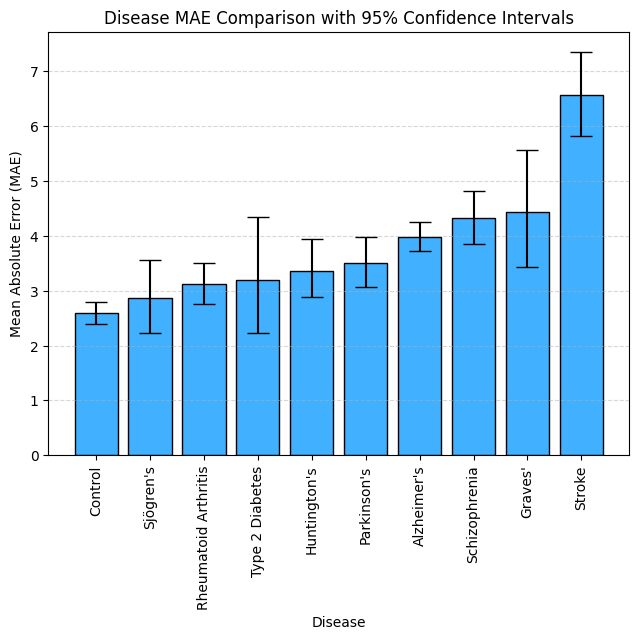

In [48]:
plt.figure(figsize=(7.5, 5.5))
plt.bar(vcresults.keys(), mae_means, yerr=np.array(error).T, capsize=8, color='#40B0FF', edgecolor='black')
plt.xlabel("Disease")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Disease MAE Comparison with 95% Confidence Intervals")
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [49]:
vresiduals = dict()
for dis in vcresults.keys():
    vresiduals[dis] = residuals[dis]
residual_data = []
for dd, rr in vresiduals.items():
    for r in rr:
        residual_data.append({'Disease': dd, 'Residual': r})
res_df = pd.DataFrame(residual_data)
res_df['Residual'] = res_df['Residual'].clip(-15, 20)
res_sample = res_df.groupby("Disease").apply(lambda x: x.sample(n=min(len(x), 100), random_state=42)).reset_index(drop=True)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


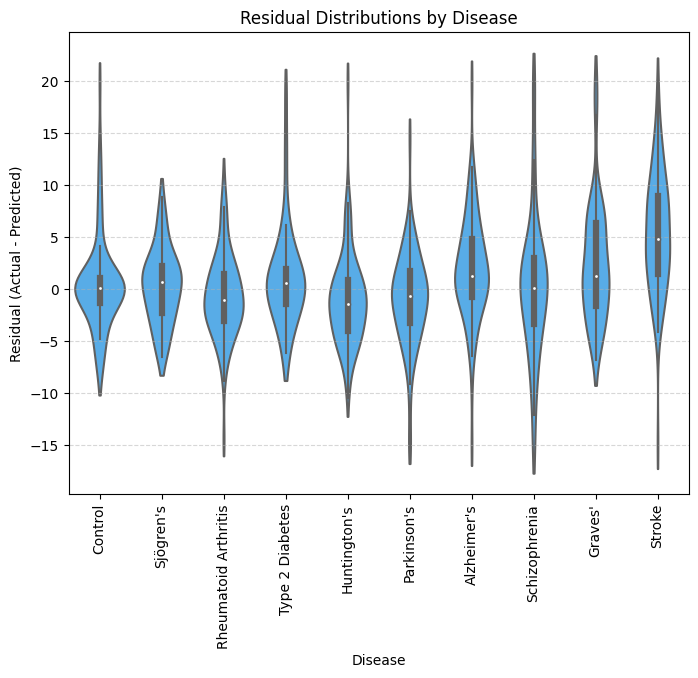

In [50]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=res_sample, x='Disease', y='Residual', inner="box", color='#40B0FF', density_norm="width", cut=1, order=list(vcresults.keys()), inner_kws=dict(box_width=7, whis_width=1))
plt.title("Residual Distributions by Disease")
plt.xlabel("Disease")
plt.ylabel("Residual (Actual - Predicted)")
plt.xticks(rotation=90, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Disease Biomarkers

In [51]:
get_cpg_info('cg04630292')

,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,...,Chromosome_36,Coordinate_36,Strand,UCSC_RefGene_Name,UCSC_RefGene_Accession,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,DMR,HMM_Island
170131,cg04630292,cg04630292,67682301.0,AAAAAAACCTAAAAAATCAAAAAACACAAAATAAAACCAAACCAAA...,70647498.0,AAAAAAACCTAAAAAATCGAAAAACGCAAAATAAAACCGAACCAAA...,I,T,Red,GGTATGACTGCAGAAAGAGCCTGGGAGATCGAGGGGCGCAGAGTGG...,...,6,32224972,R,PRRT1,NM_030651,3'UTR,chr6:32116590-32117229,Island,RDMR,6:32224481-32225389


In [52]:
def top_biomarkers_cathyp(X_disease,disease):
    T_dis = np.vstack([X_train, X_disease])
    Ty_dis = np.concatenate([np.zeros(len(X_train)),np.ones(len(X_disease))])
    S_dis = np.vstack([X_test, X_disease])
    Sy_dis = np.concatenate([np.zeros(len(X_test)),np.ones(len(X_disease))])
    cat_class = CatBoostClassifier(iterations=3200,min_data_in_leaf=1,learning_rate=0.03,max_leaves=50,l2_leaf_reg=0.1,grow_policy='Lossguide',logging_level='Silent',task_type='GPU')
    cat_class.fit(T_dis, Ty_dis)
    cat_classy = cat_class.predict(S_dis)
    plt.figure(figsize=(1.5,1.25),dpi=100)
    plt.title(disease,size=8)
    sns.heatmap(confusion_matrix(Sy_dis,cat_classy),annot=True,fmt='g',cmap='Blues',square=True,vmin=0,vmax=2000)
    plt.show()
    print(f"{disease} was classified with {round(accuracy_score(Sy_dis,cat_classy),3)*100}% accuracy.")
    print(f"{disease} was classified with f1-score of {round(f1_score(Sy_dis,cat_classy),3)*100}% accuracy.")
    explainer = shap.Explainer(cat_class)
    control_shap = explainer(S_dis)
    control_shap.feature_names = cpg_data
    shap.summary_plot(control_shap, S_dis, max_display=5)

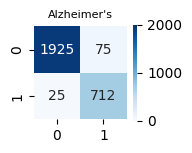

Alzheimer's was classified with 96.3% accuracy.
Alzheimer's was classified with f1-score of 93.4% accuracy.


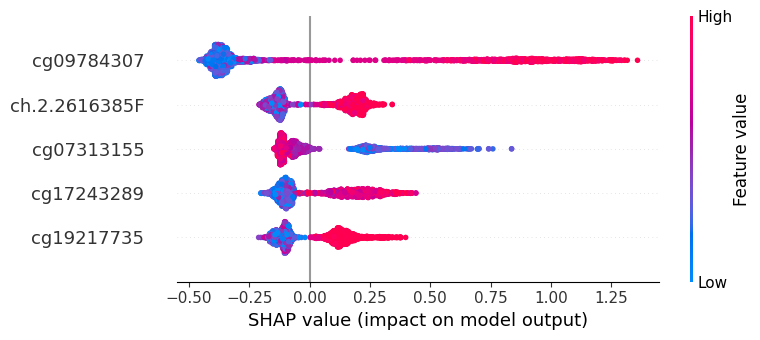

In [53]:
top_biomarkers_cathyp(X_alzhei,"Alzheimer's")

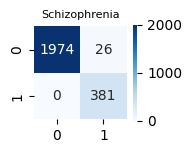

Schizophrenia was classified with 98.9% accuracy.
Schizophrenia was classified with f1-score of 96.7% accuracy.


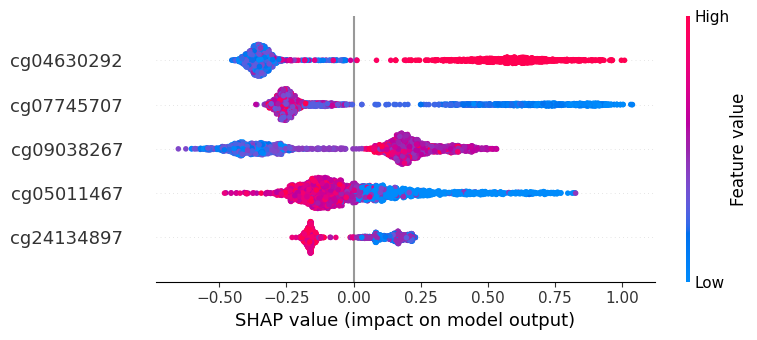

In [54]:
top_biomarkers_cathyp(X_schizo,"Schizophrenia")

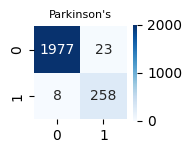

Parkinson's was classified with 98.6% accuracy.
Parkinson's was classified with f1-score of 94.3% accuracy.


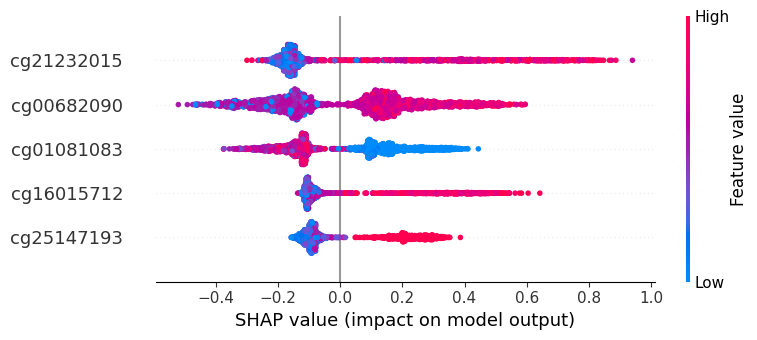

In [55]:
top_biomarkers_cathyp(X_parkin,"Parkinson's")

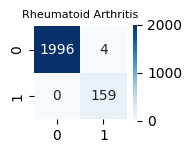

Rheumatoid Arthritis was classified with 99.8% accuracy.
Rheumatoid Arthritis was classified with f1-score of 98.8% accuracy.


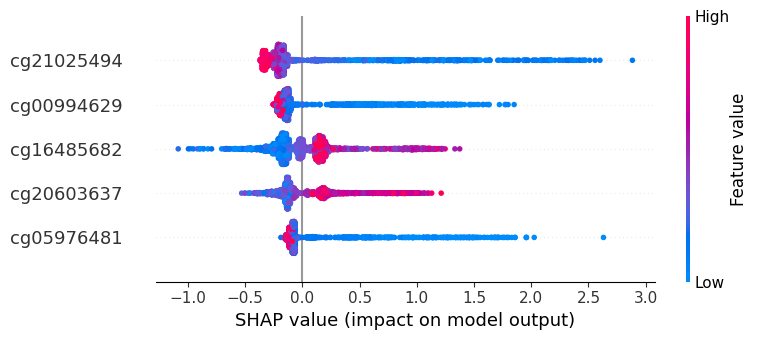

In [56]:
top_biomarkers_cathyp(X_rheuma,"Rheumatoid Arthritis")

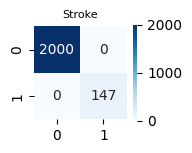

Stroke was classified with 100.0% accuracy.
Stroke was classified with f1-score of 100.0% accuracy.


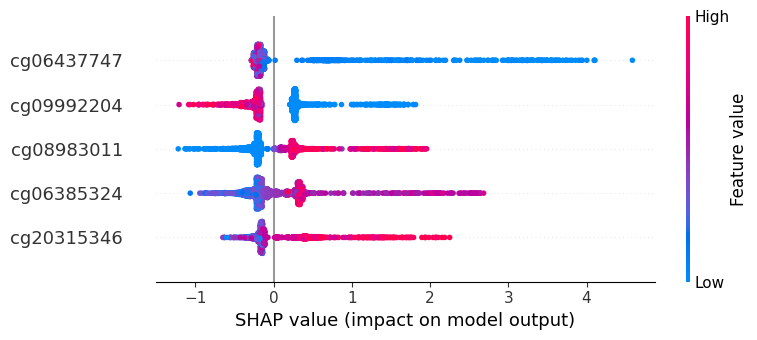

In [57]:
top_biomarkers_cathyp(X_stroke,"Stroke")

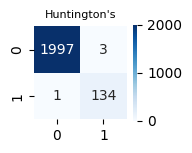

Huntington's was classified with 99.8% accuracy.
Huntington's was classified with f1-score of 98.5% accuracy.


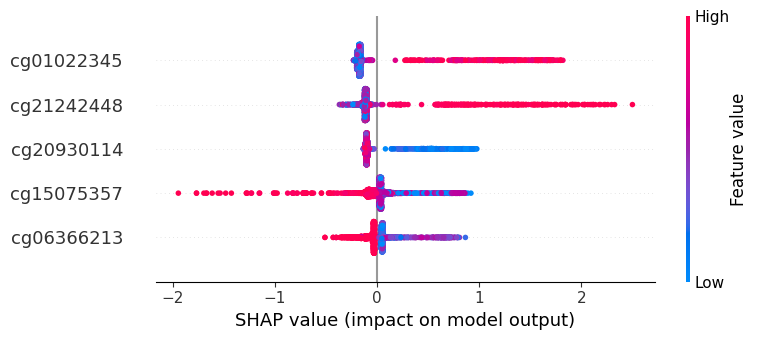

In [58]:
top_biomarkers_cathyp(X_huntin,"Huntington's")

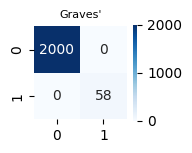

Graves' was classified with 100.0% accuracy.
Graves' was classified with f1-score of 100.0% accuracy.


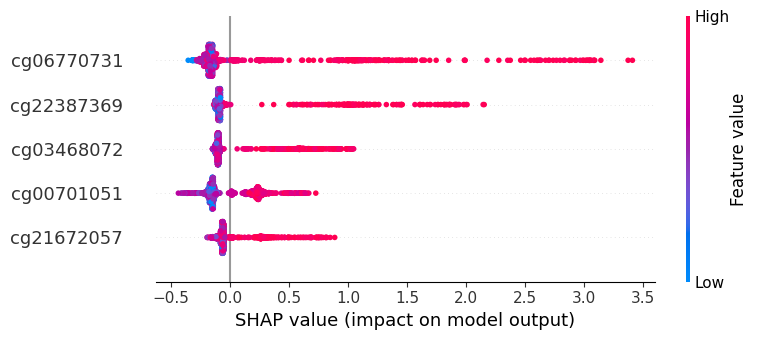

In [59]:
top_biomarkers_cathyp(X_graves,"Graves'")

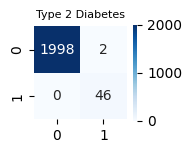

Type 2 Diabetes was classified with 99.9% accuracy.
Type 2 Diabetes was classified with f1-score of 97.89999999999999% accuracy.


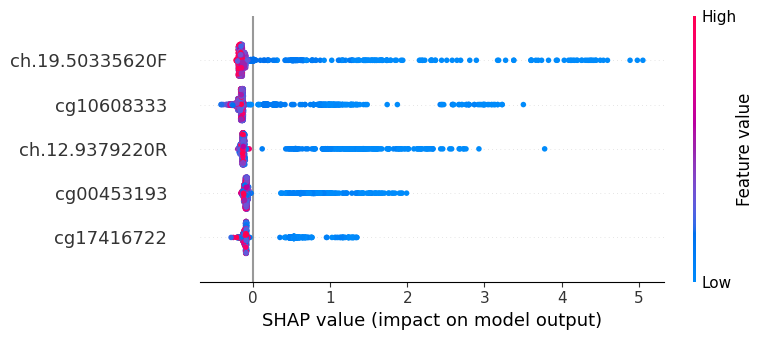

In [60]:
top_biomarkers_cathyp(X_diabet,"Type 2 Diabetes")

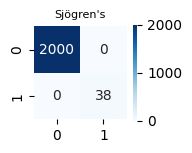

Sjögren's was classified with 100.0% accuracy.
Sjögren's was classified with f1-score of 100.0% accuracy.


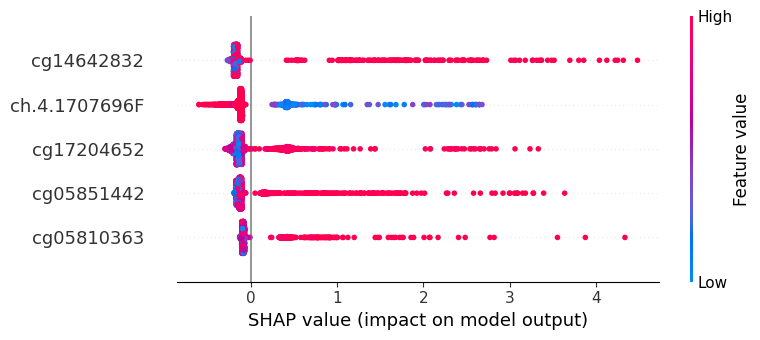

In [61]:
top_biomarkers_cathyp(X_sjogre,"Sjögren's")